<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Slice-specified-nodes-in-dimspec" data-toc-modified-id="Slice-specified-nodes-in-dimspec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Slice specified nodes in dimspec</a></span></li><li><span><a href="#Test-parallelism" data-toc-modified-id="Test-parallelism-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test parallelism</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Example-task" data-toc-modified-id="Example-task-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Example task</a></span></li></ul></li><li><span><a href="#Serial-invocation" data-toc-modified-id="Serial-invocation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Serial invocation</a></span><ul class="toc-item"><li><span><a href="#Maybe-sqash-dimensions-to-fit-into-einsum?" data-toc-modified-id="Maybe-sqash-dimensions-to-fit-into-einsum?-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Maybe sqash dimensions to fit into einsum?</a></span></li><li><span><a href="#Many-var-parallelisation" data-toc-modified-id="Many-var-parallelisation-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Many var parallelisation</a></span></li></ul></li><li><span><a href="#Plot-parallelisation-theoretical-speedup" data-toc-modified-id="Plot-parallelisation-theoretical-speedup-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot parallelisation theoretical speedup</a></span></li><li><span><a href="#Use-unix-tools" data-toc-modified-id="Use-unix-tools-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Use unix tools</a></span><ul class="toc-item"><li><span><a href="#Threading" data-toc-modified-id="Threading-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Threading</a></span></li><li><span><a href="#Multiprocessing" data-toc-modified-id="Multiprocessing-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Multiprocessing</a></span></li></ul></li></ul></li></ul></div>

In [84]:
#import ray
import pyrofiler as pyrof
from pyrofiler.pyrofiler import Profiler
from pyrofiler import callbacks
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from multiprocessing import Pool, Array
from multiprocessing.dummy import Pool as ThreadPool
import os
sns.set_style('whitegrid')
np.random.seed(42)
def work(arg):
    i,x,y, par_vars, result_idx=  arg
    patch = sliced_contract(x, y, par_vars, i)
    sl = target_slice(result_idx, par_vars, i)
pool = ThreadPool(processes=2**7)

# Slice specified nodes in dimspec

In [85]:
def _none_slice():
    return slice(None)

def _get_idx(x, idxs, slice_idx, shapes=None):
    if shapes is None:
        shapes = [2]*len(idxs)
    point = np.unravel_index(slice_idx, shapes)
    get_point = {i:p for i,p in zip(idxs, point)}
    if x in idxs:
        p = get_point[x]
        return slice(p,p+1)
    else:
        return _none_slice()

def _slices_for_idxs(idxs, *args, shapes=None, slice_idx=0):
    """Return array of slices along idxs"""
    slices = []
    for indexes in args:
        _slice = [_get_idx(x, idxs, slice_idx, shapes) for x in indexes ]
        slices.append(tuple(_slice))
    return slices
        

In [86]:
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

# Test parallelism
### Example task

In [87]:
def get_example_task(A=8, B=10, C=7, dim1=0):
    shape1 = [2]*(A+B)
    shape2 = [2]*(A+C)
    for i in range(dim1):
        shape1[-i] = 1
        shape2[-i] = 1

    T1 = np.random.randn(*shape1)
    T2 = np.random.randn(*shape2)
    common = list(range(A))
    idxs1 = common + list(range(A, A+B))
    idxs2 = common + list(range(A+B, A+B+C))
    return (T1, idxs1), (T2, idxs2)

x, y = get_example_task(A=9)
x[1], y[1]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 20, 21, 22, 23, 24, 25])

## Serial invocation

In [88]:
def contract(A, B):
    a, idxa = A
    b, idxb = B
    contract_idx = set(idxa) & set(idxb)
    result_idx = set(idxa + idxb)
    print('contract result idx',result_idx)
    C = np.einsum(a,idxa, b,idxb, result_idx)
    return C

def sliced_contract(x, y, idxs, num):
    slices = _slices_for_idxs(idxs, x[1], y[1], slice_idx=num)
    a = x[0][slices[0]]
    b = y[0][slices[1]]
    with pyrof.timing(f'\tcontract sliced {num}'):
        C = contract((a, x[1]), (b, y[1]))
    return C

def target_slice(result_idx, idxs, num):
    slices = _slices_for_idxs(idxs, result_idx, slice_idx=num)
    return slices

with pyrof.timing('contract'):
    C = contract(x, y)

contract result idx {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
contract : 0.7865877151489258


### Maybe sqash dimensions to fit into einsum?

In [89]:
def __contract_bound(A, B):
    a, idxa = A
    b, idxb = B
    contract_idx = set(idxa) & set(idxb)
    def glue_first(shape):
        sh = [shape[0] * shape[1]] + list(shape[2:])
        return sh
    
    result_idx = set(idxa + idxb)
    _map_a = {k:v for k,v in zip(idxa, a.shape)}
    _map_b = {k:v for k,v in zip(idxb, b.shape)}
    _map = {**_map_a, **_map_b}
    print(_map)
    result_idx = sorted(tuple(_map.keys()))
    target_shape = tuple([_map[i] for i in result_idx])
    
    
            
    _dimlen = len(result_idx)
    _maxdims = 22
    print('dimlen',_dimlen)
    new_a, new_b = a.shape, b.shape
    if _dimlen>_maxdims:
        _contr_dim = _dimlen - _maxdims
        print(len(new_a), len(new_b))
        for i in range(_contr_dim):
            idxa = idxa[1:]
            idxb = idxb[1:]
                    
            new_a = glue_first(new_a)
            new_b = glue_first(new_b)
            
    _map_a = {k:v for k,v in zip(idxa, a.shape)}
    _map_b = {k:v for k,v in zip(idxb, b.shape)}
    _map = {**_map_a, **_map_b}
    print(_map)
    result_idx = sorted(tuple(_map.keys()))
    print(len(new_a), len(new_b))
    a = a.reshape(new_a)
    b = b.reshape(new_b)
    print(a.shape, b.shape)
    print(idxa, idxb)
    print('btsh',result_idx, target_shape)
        
        
    C = np.einsum(a,idxa, b,idxb, result_idx)
    
    return C.reshape(*target_shape)

def __add_dims(x, dims, ofs):
    arr, idxs = x
    arr = arr.reshape(list(arr.shape) + [1]*dims)
    md = max(idxs)
    return arr, idxs + list(range(md+ofs, ofs+md+dims)) 


### Many var parallelisation

In [90]:
prof_seq = Profiler()
prof_seq.use_append()

contract_idx = set(x[1]) & set(y[1])
result_idx = set(x[1] + y[1])

for i in range(1):
    _ = contract(x,y)
for rank in range(1,7):
    with prof_seq.timing('Single thread'):
        C = contract(x,y)
    
    par_vars = list(range(rank))
    target_shape = C.shape

    with prof_seq.timing('One patch: total'):
        i = 0
        with prof_seq.timing('One patch: compute'):
            patch = sliced_contract(x, y, par_vars, i)
        C_par = np.empty(target_shape)
        with prof_seq.timing('One patch: assign'):
            _slice = target_slice(result_idx, par_vars, i)
            C_par[_slice[0]] = patch


contract result idx {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
contract result idx {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


KeyboardInterrupt: 

## Plot parallelisation theoretical speedup

In [ ]:
prof_seq.data
threads = 2**np.arange(1,7)
C_size = sys.getsizeof(C)

for k in prof_seq.data:
    plt.plot(threads, prof_seq.data[k], label=k)
    
plt.loglog(basex=2, basey=2)
from matplotlib.ticker import FormatStrFormatter

plt.title(f'Single node parallelization one batch test. Task size: {C_size:e}')
plt.xlabel('Thread count')
plt.ylabel('Time')
minorticks()
plt.legend()
plt.savefig('figures/node_par_seqtest.pdf')
plt.close()

## Use unix tools
### Threading

In [ ]:
x,y = get_example_task(A=20, B=9, C=8, dim1=2)
contract_idx = set(x[1]) & set(y[1])
result_idx = set(x[1] + y[1])

In [ ]:

prof_thread = Profiler()
prof_thread.use_append()


for i in range(1):
    C = contract(x,y)

C_size = sys.getsizeof(C)
target_shape = C.shape
C = None
    
    
for rank in range(1,7):
    if rank==1:
        with prof_thread.timing('Single thread'):
            C = contract(x,y)

    C = None
    with prof_thread.timing('Multithread: total'):
        par_vars = list(range(rank))
        threads = 2**len(par_vars)

        os.global_C = np.empty(target_shape)


        with prof_thread.timing('Multithread: work'):
            _ = pool.map(work, ((i,x,y,par_vars,result_idx)for i in range(threads)))
            
#assert np.array_equal(C, os.global_C)

In [ ]:
_data = prof_thread.data
print(_data)

_data_knl = {'Single thread': [1.3409993648529053, 1.3587844371795654, 1.3243846893310547, 1.336273193359375, 1.3332529067993164, 1.3412296772003174], 'Multithread: work': [0.7453043460845947, 0.5046432018280029, 0.39226293563842773, 0.40014123916625977, 0.5875647068023682, 1.0763416290283203], 'Multithread: total': [0.7459092140197754, 0.5054154396057129, 0.3927571773529053, 0.4007418155670166, 0.588019847869873, 1.0771734714508057]}
_data_biggest = {'Single thread': [27.42847204208374, 26.855594873428345, 26.628530979156494, 26.862286806106567, 26.71247911453247, 27.049968957901], 'Multithread: work': [14.236661434173584, 7.511402368545532, 4.950175762176514, 3.012814521789551, 2.351712703704834, 1.994131088256836], 'Multithread: total': [14.23719048500061, 7.512014150619507, 4.950707912445068, 3.0133090019226074, 2.3522441387176514, 1.9946098327636719]}
#_data = _data_biggest


threads = 2**np.arange(1,7)

for k in _data:
    plt.plot(threads, _data[k], label=k)

plt.loglog(basex=2, basey=2)
plt.yscale('linear')
from matplotlib.ticker import FormatStrFormatter

plt.title(f'Single node parallelization test. Task size: {C_size:e}')
plt.xlabel('Thread count')
plt.ylabel('Time')
minorticks()

plt.legend()
plt.savefig('figures/node_par_threadtest_biggest.pdf')

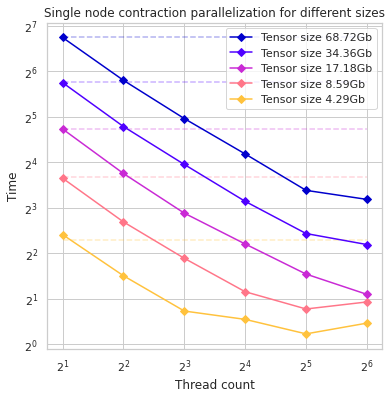

In [108]:
#plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True})
sns.set_style('whitegrid')
#sns.set()
_data_block = {
    '28':{'Single thread': [4.890172481536865], 'Multithread: work': [5.31355881690979, 2.839036464691162, 1.6587004661560059, 1.4607517719268799, 1.1708364486694336, 1.3796212673187256], 'Multithread: total': [5.31405234336853, 2.839534282684326, 1.659132957458496, 1.4612171649932861, 1.1718018054962158, 1.380187749862671]}
    ,'29': {'Single thread': [12.708141088485718], 'Multithread: work': [12.543375015258789, 6.445459604263306, 3.702291250228882, 2.225062131881714, 1.7111496925354004, 1.9049854278564453], 'Multithread: total': [12.543986320495605, 6.445924997329712, 3.7027952671051025, 2.2256860733032227, 1.7118234634399414, 1.905548095703125]}
   , '30': {'Single thread': [26.65827775001526], 'Multithread: work': [26.532104015350342, 13.471351146697998, 7.361323356628418, 4.6045496463775635, 2.9114484786987305, 2.138317108154297], 'Multithread: total': [26.532758712768555, 13.471930980682373, 7.363482475280762, 4.605044364929199, 2.91215181350708, 2.1388139724731445]}
   , '31': {'Single thread': [54.215914249420166], 'Multithread: work': [53.743674755096436, 27.541589498519897, 15.45585584640503, 8.812772750854492, 5.398884296417236, 4.5649192333221436], 'Multithread: total': [53.74607563018799, 27.542162895202637, 15.456344604492188, 8.814988851547241, 5.399648427963257, 4.5654377937316895]}
   , '32': {'Single thread': [107.05718398094177], 'Multithread: work': [106.85966396331787, 55.66744685173035, 31.097278356552124, 18.133748292922974, 10.42065167427063, 9.078657865524292], 'Multithread: total': [106.86018991470337, 55.669677734375, 31.099481344223022, 18.13595175743103, 10.421445369720459, 9.080750703811646]}
}

threads = 2**np.arange(1,7)
fig, axs = plt.subplots(1,1, figsize=(6,6))
colors = (plt.cm.gnuplot2(x) for x in np.linspace(.8,.2,len(_data_block)))

for size, _data in _data_block.items():
    singl = _data['Single thread']
    total = _data['Multithread: total']
    c = next(colors)
    plt.plot(threads, total, '-D',color=c, label=f'Tensor size {2**(4+int(size))/1e9:.2f}Gb')
    plt.plot(threads, singl*len(threads), '--', alpha=.3, color=c )

#from matplotlib.ticker import FormatStrFormatter
plt.loglog(basex=2, basey=2)
#plt.yscale('linear')

plt.grid()
#minorticks()
ax = plt.gca()
#ax.yaxis.set_minor_locator(plt.ticker.LogLocator(base=10.0, subs='all'))
#ax.yaxis.set_minor_formatter(plt.ticker.NullFormatter())

plt.title(f'Single node contraction parallelization for different sizes')
plt.xlabel('Thread count')
plt.ylabel('Time')

plt.grid(True,which="both")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right')

plt.savefig('figures/node_par_threadtest_gener_jlse.pdf')

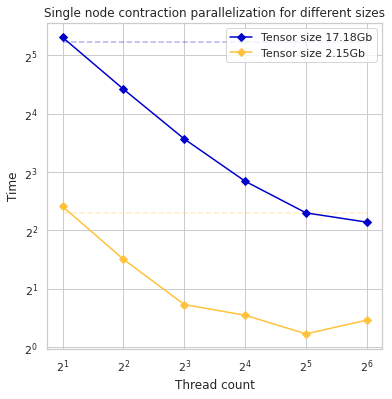

In [109]:
#plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True})
sns.set_style('whitegrid')
#sns.set()
_data_block = {
    '27':{'Single thread': [4.890172481536865], 'Multithread: work': [5.31355881690979, 2.839036464691162, 1.6587004661560059, 1.4607517719268799, 1.1708364486694336, 1.3796212673187256], 'Multithread: total': [5.31405234336853, 2.839534282684326, 1.659132957458496, 1.4612171649932861, 1.1718018054962158, 1.380187749862671]}
    ,'30': {'Single thread': [37.403658866882324], 'Multithread: work': [39.51915979385376, 21.37852430343628, 11.835341453552246, 7.165068864822388, 4.922534942626953, 4.410918235778809], 'Multithread: total': [39.519590854644775, 21.378950595855713, 11.83582329750061, 7.1655051708221436, 4.923001050949097, 4.411387205123901
]}

}

threads = 2**np.arange(1,7)
fig, axs = plt.subplots(1,1, figsize=(6,6))
colors = (plt.cm.gnuplot2(x) for x in np.linspace(.8,.2,len(_data_block)))

for size, _data in _data_block.items():
    singl = _data['Single thread']
    total = _data['Multithread: total']
    c = next(colors)
    plt.plot(threads, total, '-D',color=c, label=f'Tensor size {2**(4+int(size))/1e9:.2f}Gb')
    plt.plot(threads, singl*len(threads), '--', alpha=.3, color=c )

#from matplotlib.ticker import FormatStrFormatter
plt.loglog(basex=2, basey=2)
#plt.yscale('linear')

plt.grid()
#minorticks()
ax = plt.gca()
#ax.yaxis.set_minor_locator(plt.ticker.LogLocator(base=10.0, subs='all'))
#ax.yaxis.set_minor_formatter(plt.ticker.NullFormatter())

plt.title(f'Single node contraction parallelization for different sizes')
plt.xlabel('Thread count')
plt.ylabel('Time')

plt.grid(True,which="both")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right')

plt.savefig('figures/node_par_threadtest_gener_theta.pdf')

###  Multiprocessing

In [ ]:

flat_size = len(C.flatten())
with pyrof.timing('init array'):
    os.global_C = np.empty(target_shape)
    #os.global_C = tonumpyarray(Array('d', flat_size))
#us.global_C = os.global_C.reshape(target_shape)

pool = Pool(processes=threads)
print('inited pool')
with pyrof.timing('parallel work'):
    print('started work')
    _ = pool.map(work, range(threads))

C_size = sys.getsizeof(os.global_C)
print(f'result size: {C_size:e}')
assert np.array_equal(C, os.global_C)


In [ ]:
del os.global_C